In [35]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, confusion_matrix
import collections
from matplotlib import pyplot as plt
from torchvision import transforms
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

Separação de dados principais

In [18]:
df = pd.read_csv('classifications.csv')

In [171]:
# Caminho para o diretório desejado
!unzip 'imagens_segmentadas.zip'

'unzip' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [19]:
caminho_diretorio ='imagem_segmentada/'

#Listar arquivos no diretório
arquivos = os.listdir(caminho_diretorio)

# Exibir os arquivos
print(arquivos)

['10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '2.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '3.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '4.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '5.png', '6.png', '7.png', '8.png', '9.png']


In [20]:
df['cell_id'] = df['cell_id'].astype(str)

# Mapeando os tipos de células para as imagens
ids_imagens = [os.path.splitext(imagem)[0] for imagem in arquivos]
df_filtrado = df[df['cell_id'].isin(ids_imagens)]

# Caminho completo para o diretório de imagens
caminho_completo = [os.path.join(caminho_diretorio, f"{id}.png") for id in ids_imagens]

# Carregar as imagens
imagens = [Image.open(caminho) for caminho in caminho_completo]

# Exemplo de redimensionamento e normalização
preprocessamento = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

imagens_processadas = [preprocessamento(imagem) for imagem in imagens]

# Divisão estratificada entre treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(
    imagens_processadas, df_filtrado['bethesda_system'],
    test_size=0.2, random_state=42, stratify=df_filtrado['bethesda_system']
)


Quantidade de imagens de treino: 36
Quantidade de imagens de teste: 10


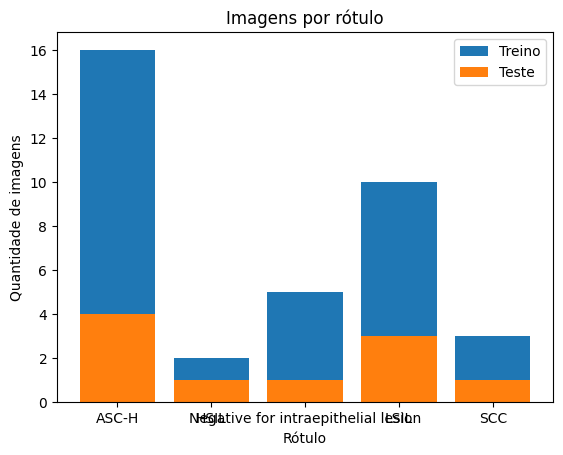

In [21]:
import collections
from matplotlib import pyplot

rotulos = df_filtrado['bethesda_system']

# Checando quantidade de imagens do dataset
print('Quantidade de imagens de treino:', len(x_treino))
print('Quantidade de imagens de teste:', len(x_teste))

# Contando quantidade de imagens por rótulo
counterTreino = collections.Counter(y_treino)
counterTeste = collections.Counter(y_teste)

# Plotando quantidade de imagens de cada rótulo
fig, ax = pyplot.subplots()
rects1 = ax.bar(counterTreino.keys(), counterTreino.values(), label='Treino')
rects2 = ax.bar(counterTeste.keys(), counterTeste.values(), label='Teste')

ax.set_title('Imagens por rótulo')
ax.set_ylabel('Quantidade de imagens')
ax.set_xlabel('Rótulo')
ax.legend()
pyplot.show()

# Classificação de Mahalnobis

Distância de Mahalanobis:  [363.09270687  47.95087199   7.71087389 184.50334742  59.70497553
  62.15281094  26.50480181 108.83440928  42.8987337   31.3900867 ]
Acurácia:  0.1
Matriz de Confusão:
[[1 0]
 [9 0]]


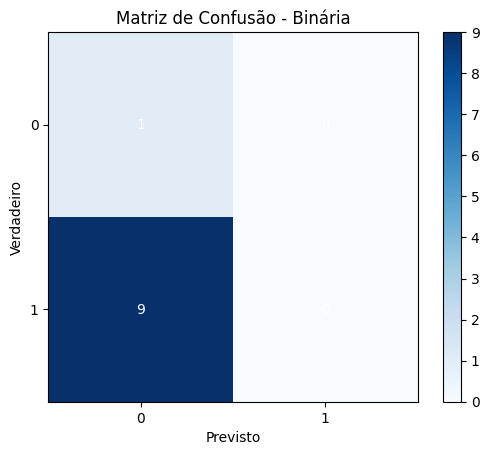

In [22]:
# Converter para numpy arrays
x_treino_np = np.array([img.numpy().flatten() for img in x_treino])
x_teste_np = np.array([img.numpy().flatten() for img in x_teste])

# Mapeamento de classes
class_mapping = {'Negative for intraepithelial lesion': 0}

# Atribuir rótulo 1 para todas as outras classes
for label in df_filtrado['bethesda_system'].unique():
    if label not in class_mapping:
        class_mapping[label] = 1

# Mapeamento dos rótulos verdadeiros
y_true_int = np.array([class_mapping[label] for label in y_teste])

# Aplicar PCA para reduzir a dimensionalidade
n_components = min(x_treino_np.shape[0], x_treino_np.shape[1])
pca = PCA(n_components=n_components)
x_treino_pca = pca.fit_transform(x_treino_np)
x_teste_pca = pca.transform(x_teste_np)

# Calcular a matriz de covariância e seu inverso para o conjunto de treino reduzido
cov_matrix = np.cov(x_treino_pca, rowvar=False)
regularization_term = 1e-5
cov_matrix_regularized = cov_matrix + regularization_term * np.eye(cov_matrix.shape[0])
inv_cov_matrix = np.linalg.inv(cov_matrix_regularized)

# Calcular a distância Mahalanobis
mahalanobis_dist = [distance.mahalanobis(imagem, np.mean(x_treino_pca, axis=0), inv_cov_matrix) for imagem in x_teste_pca]
mahalanobis_dist_array = np.array(mahalanobis_dist)

# Ajustar o limiar conforme necessário
limiar = 5.0

# Criar rótulos previstos com base nas distâncias
y_pred_int = [0 if dist > limiar else 1 for dist in mahalanobis_dist_array]

# Calcular a acurácia usando y_true_int e y_pred_int
acc_binary = accuracy_score(y_true_int, y_pred_int)

# Calcular a matriz de confusão
cm_binary = confusion_matrix(y_true_int, y_pred_int)

# Exibir resultados
print("Distância de Mahalanobis: ", mahalanobis_dist_array)
print("Acurácia: ", acc_binary)
print("Matriz de Confusão:")
print(cm_binary)

# Plotar a matriz de confusão
plt.imshow(cm_binary, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Binária')
plt.colorbar()

# Adicionar anotações
for i in range(cm_binary.shape[0]):
    for j in range(cm_binary.shape[1]):
        plt.text(j, i, str(cm_binary[i, j]), ha='center', va='center', color='white')

# Adicionar rótulos
classes = np.unique(y_true_int)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

Distâncias de Mahalanobis:  [363.09270687  47.95087199   7.71087389 184.50334742  59.70497553
  62.15281094  26.50480181 108.83440928  42.8987337   31.3900867 ]
Acurácia:  0.0
Matriz de Confusão:
[[0 0]
 [1 0]]


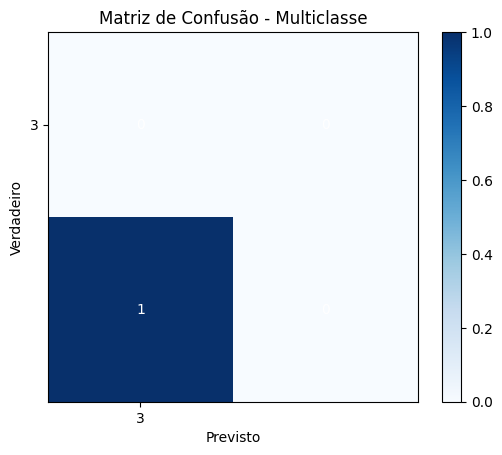

In [33]:
x_treino_np = np.array([img.numpy().flatten() for img in x_treino])
x_teste_np = np.array([img.numpy().flatten() for img in x_teste])

# Mapeamento de classes
class_mapping = {label: i for i, label in enumerate(df_filtrado['bethesda_system'].unique())}

# Mapeamento dos rótulos verdadeiros
y_true_int = np.array([class_mapping[label] for label in y_teste])

# Aplicar PCA para reduzir a dimensionalidade
n_components = min(x_treino_np.shape[0], x_treino_np.shape[1])
pca = PCA(n_components=n_components)
x_treino_pca = pca.fit_transform(x_treino_np)
x_teste_pca = pca.transform(x_teste_np)

# Calcular a matriz de covariância e seu inverso para o conjunto de treino reduzido
cov_matrix = np.cov(x_treino_pca, rowvar=False)
regularization_term = 1e-5
cov_matrix_regularized = cov_matrix + regularization_term * np.eye(cov_matrix.shape[0])
inv_cov_matrix = np.linalg.inv(cov_matrix_regularized)

# Calcular a distância Mahalanobis
mahalanobis_dist = [distance.mahalanobis(imagem, np.mean(x_treino_pca, axis=0), inv_cov_matrix) for imagem in x_teste_pca]
mahalanobis_dist_array = np.array(mahalanobis_dist)

# Ajustar o limiar conforme necessário
limiar = 5.0

# Criar rótulos previstos com base nas distâncias
y_pred_int = np.argmin(mahalanobis_dist_array, axis=0)

# Ajustar a forma de y_true_int
y_true_int = y_true_int.ravel()

# Ajustar a forma de y_pred_int
y_pred_int = y_pred_int.ravel()

# Garantir que y_true_int e y_pred_int tenham o mesmo número de amostras
min_samples = min(len(y_true_int), len(y_pred_int))
y_true_int = y_true_int[:min_samples]
y_pred_int = y_pred_int[:min_samples]

# Calcular a acurácia usando y_true_int e y_pred_int
acc_multiclass = accuracy_score(y_true_int, y_pred_int)

# Calcular a matriz de confusão
cm_multiclass = confusion_matrix(y_true_int, y_pred_int)

# Exibir resultados
print("Distâncias de Mahalanobis: ", mahalanobis_dist_array)
print("Acurácia: ", acc_multiclass)
print("Matriz de Confusão:")
print(cm_multiclass)

# Plotar a matriz de confusão
plt.imshow(cm_multiclass, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Multiclasse')
plt.colorbar()

# Adicionar anotações
for i in range(cm_multiclass.shape[0]):
    for j in range(cm_multiclass.shape[1]):
        plt.text(j, i, str(cm_multiclass[i, j]), ha='center', va='center', color='white')

# Adicionar rótulos
classes = np.unique(y_true_int)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

# Classificação CNN

In [36]:
class EfficientNetBinary(nn.Module):
    def __init__(self):
        super(EfficientNetBinary, self).__init__()
        self.model = torchvision.models.efficientnet_b0(pretrained=True)
        self.model.classifier[1] = nn.Linear(1280, 2)

    def forward(self, x):
        return self.model(x)


class EfficientNetMulti(nn.Module):
    def __init__(self):
        super(EfficientNetMulti, self).__init__()
        self.model = torchvision.models.efficientnet_b0(pretrained=True)
        self.model.classifier[1] = nn.Linear(1280, 6)

    def forward(self, x):
        return self.model(x)

In [37]:
from PIL import Image
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Check if the image or label is None and handle it
        if image is None or label is None:
            # Return special values to indicate that this sample should be ignored
            return torch.zeros(3, 224, 224), torch.tensor(-1, dtype=torch.long)

        # Check if the image is a tensor and convert it to a PIL Image if needed
        if not isinstance(image, Image.Image):
            image = transforms.ToPILImage()(image)

        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label_tensor = torch.tensor(label, dtype=torch.long)

        return image, label_tensor


In [38]:
!wget https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True

'wget' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [39]:
import urllib.request

url = "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth"
destination = "/root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth"

urllib.request.urlretrieve(url, destination)

efficientnet_binary = EfficientNetBinary()
efficientnet_multi = EfficientNetMulti()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_binary.parameters(), lr=0.0001)

FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth'

In [40]:
# Load and preprocess images
images = []
labels = []

for img_path in caminho_completo:
    image = Image.open(img_path)
    image = preprocessamento(image)
    images.append(image)

    filtered_data = df_filtrado[df_filtrado['cell_id'] == os.path.splitext(img_path)[0]]
    if not filtered_data.empty:
        label = filtered_data['bethesda_system'].values[0]
        labels.append(label)
    else:
        # Handle the case when there is no matching data for the image
        labels.append(None)  # or any default label

# Create the dataset
dataset = CustomDataset(images, labels, preprocessamento)

# Create the dataloader
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Create the dataset for test
test_dataset = CustomDataset(test_images, test_labels, preprocessamento)

# Create the dataloader for test
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Train the model
for epoch in range(100):
    # Train
    efficientnet_binary.train()
    for i, data in enumerate(train_loader):
        inputs, train_labels = data

        # Filtrar amostras com rótulos inválidos (-1)
        valid_samples = (train_labels != -1)
        valid_inputs = inputs[valid_samples]
        valid_train_labels = train_labels[valid_samples]

        optimizer.zero_grad()
        outputs = efficientnet_binary(valid_inputs)
        loss = criterion(outputs, valid_train_labels)
        loss.backward()
        optimizer.step()

    # Evaluate on test set
    efficientnet_binary.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, data in enumerate(test_loader):
            inputs, test_labels = data
            outputs = efficientnet_binary(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum().item()
        accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}, Accuracy on test set: {accuracy:.2f}%")

# Acurácia de treino
efficientnet_binary.train()
correct = 0
total = 0
for i, data in enumerate(train_loader):
    inputs, labels = data
    outputs = efficientnet_binary(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
accuracy_train = 100 * correct / total

# Acurácia de teste
efficientnet_binary.eval()
correct = 0
total = 0
for i, data in enumerate(test_loader):
    inputs, labels = data
    outputs = efficientnet_binary(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
accuracy_test = 100 * correct / total

NameError: name 'test_images' is not defined

In [ ]:
# Train the model
for epoch in range(100):
    # Train
    efficientnet_binary.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data

        # Ignore samples with label -1 during loss calculation
        valid_samples = (labels != -1)
        valid_inputs = inputs[valid_samples]
        valid_labels = labels[valid_samples]

        optimizer.zero_grad()
        outputs = efficientnet_binary(valid_inputs)
        loss = criterion(outputs, valid_labels)
        loss.backward()
        optimizer.step()

    # Evaluate
    efficientnet_binary.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, data in enumerate(test_loader):
            inputs, labels = data
            outputs = efficientnet_binary(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}: {accuracy:.2f}%")

In [ ]:
# Acurácia de treino
efficientnet_binary.train()
correct = 0
total = 0
for i, data in enumerate(train_loader):
    inputs, labels = data
    outputs = efficientnet_binary(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
accuracy_train = 100 * correct / total

# Acurácia de teste
efficientnet_binary.eval()
correct = 0
total = 0
for i, data in enumerate(test_loader):
    inputs, labels = data
    outputs = efficientnet_binary(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
accuracy_test = 100 * correct / total
